# 深圳签订外贸合同量预测ARIMA模型

## 使用到的模块及其安装

 - Python version: 3.11.0

 - Pandas version: 2.2.3
    - pip install pandas==2.2.3

 - NumPy version: 2.2.2
    - pip install numpy==2.2.2

 - tqdm version: 4.67.1
    - pip install tqdm==4.67.1

 - Matplotlib version: 3.10.1
    - pip install matplotlib==3.10.1

 - Seaborn version: 0.13.2
    - pip install seaborn==0.13.2

 - pmdarima version: 2.0.4
    - pip install pmdarima==2.0.4
    
 - Statsmodels version:
    - pip install statsmodels==0.14.4

 - SciKit-Learn version: 1.6.1
    - pip install scikit-learn==1.6.1

 - keras version: 3.9.0
    - pip install keras==3.9.0

In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
from tqdm import trange, tqdm
from scipy.interpolate import interp1d

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.simplefilter('ignore', category=UserWarning)

from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns
import matplotlib as mpl
mpl.rcParams['font.family'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_excel('深圳签订外贸合同项数数据1990~2023.xlsx')

# 获取全部的列名列表
# all_columns = df.columns.tolist()
# print(all_columns)

# 输入一个需要预测的国家或地区
"""
    '中国香港、澳门', '中国台湾', '新加坡', '韩国', '日本', 
    '泰国', '澳大利亚', '马来西亚', '美国', '加拿大', 
    '德国', '法国', '英国', '瑞士', '荷兰', '其他'
"""
need_to_predict = str(input("请输入您需要预测的国家："))
# need_to_predict = "其他"
# print(need_to_predict)
# years_to_predicted = int(input("请输出需要预测未来多少年的数据"))
years_to_predicted = 20
print(f"预测未来{years_to_predicted}年内{need_to_predict}的数据")

# 保留单一列数据，用于预测。这里以用户指定的国家/地区为例（'中国香港、澳门'）。
df_total = df[['日期', need_to_predict]].copy()

print('原数据预览：\n', df.head())
print('保留后数据预览：\n', df_total.head())

预测未来20年内中国香港、澳门的数据
原数据预览：
           日期  中国香港、澳门  中国台湾  新加坡  韩国  日本  泰国  澳大利亚  马来西亚   美国  加拿大  德国  法国  \
0 1990-01-01      699    45    5   0  12   2     2     1   16    2   0   1   
1 1991-01-01      885    36    8   3  17   3     1     0   18    2   2   3   
2 1992-01-01     1330    88   20   5  16   8     6     3   57    8   1   2   
3 1993-01-01     2834   154   24   8  27  15    14     5  104   22   2   4   
4 1994-01-01     1885   124   29   8  25   8     7     3   74   10   5   3   

   英国  瑞士  荷兰  其他  
0   2   3   0   6  
1   2   1   1   4  
2   5   0   1  11  
3  16   2   3  23  
4  19   0   1  22  
保留后数据预览：
           日期  中国香港、澳门
0 1990-01-01      699
1 1991-01-01      885
2 1992-01-01     1330
3 1993-01-01     2834
4 1994-01-01     1885


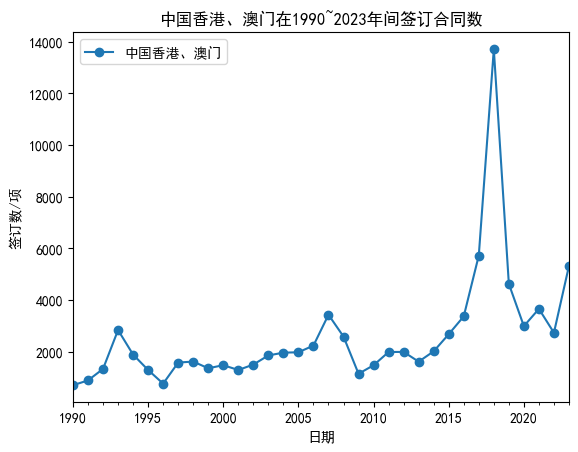

In [3]:
# 修改列标题
df_total.columns = ["日期", need_to_predict]
# 转化时间数据为 datetime 对象
df_total['日期'] = pd.to_datetime(df_total['日期'], format='%Y')

# 设置时间索引
df_total.set_index('日期', inplace=True)
df_total.head()

# 原始数据可视化绘图
df_total.plot(kind='line', marker='o')
plt.title(f"{need_to_predict}在1990~2023年间签订合同数")
plt.ylabel('签订数/项')
plt.show()

### 数据预处理

In [4]:
# 绘制函数
def plots_scatterAboxplot(df_total):
    # 设置画布大小和布局
    plt.figure(figsize=(10, 4))
    plt.subplots_adjust(wspace=0.3)  # 子图之间的水平间距
    # 绘制当前数据散点图
    plt.subplot(1, 2, 1)
    plt.scatter(df_total.index, df_total[need_to_predict], color='blue', alpha=0.7)
    plt.title(f"{need_to_predict} - 散点图", fontsize=12)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel("签订数/项", fontsize=10)
    # 绘制当前数据箱线图
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_total[[need_to_predict]], palette='viridis')
    plt.title(f"{need_to_predict} - 箱线图", fontsize=12)
    plt.ylabel("签订数/项", fontsize=10)
    plt.tight_layout()
    plt.show()

# 三倍标准差清理数据
def three_sigma(df_total):
    print("-------------- 三倍标准差清理 --------------")
    # 计算均值和标准差
    mean_value = df_total[need_to_predict].mean()  # 均值
    std_value = df_total[need_to_predict].std()    # 标准差
    print(f"原始数据统计信息 ({need_to_predict}):")
    print(df_total[need_to_predict].describe())
    # 定义异常值范围
    lower_bound = mean_value - 3 * std_value
    upper_bound = mean_value + 3 * std_value
    print(f"异常值范围：[{lower_bound}, {upper_bound}]")
    # 筛选数据，移除异常值
    df_cleaned = df_total[(df_total[need_to_predict] >= lower_bound) & (df_total[need_to_predict] <= upper_bound)]
    # 输出清理后的数据统计信息
    print(f"清理后的数据统计信息 ({need_to_predict}):")
    print(df_cleaned[need_to_predict].describe())
    # 输出移除的异常值数量
    num_removed = len(df_total) - len(df_cleaned)
    print(f"移除的异常值数量：{num_removed} ({num_removed / len(df_total) * 100:.2f}%)", end="\n----------------------------\n")
    return df_cleaned

# 四分位距（IQR）清理数据
def IQR_fun(df_total):
    print("-------------- IQR清理 --------------")
    # 计算四分位数
    Q1 = df_total[need_to_predict].quantile(0.25)  # 第一四分位数
    Q3 = df_total[need_to_predict].quantile(0.75)  # 第三四分位数
    IQR = Q3 - Q1  # 四分位距
    print(f"原始数据统计信息 ({need_to_predict}):")
    print(df_total[need_to_predict].describe())
    # 定义异常值范围
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"异常值范围：[{lower_bound}, {upper_bound}]")
    # 筛选数据，移除异常值
    df_cleaned = df_total[(df_total[need_to_predict] >= lower_bound) & (df_total[need_to_predict] <= upper_bound)]
    # 输出清理后的数据统计信息
    print(f"清理后的数据统计信息 ({need_to_predict}):")
    print(df_cleaned[need_to_predict].describe())
    # 输出移除的异常值数量
    num_removed = len(df_total) - len(df_cleaned)
    print(f"移除的异常值数量：{num_removed} ({num_removed / len(df_total) * 100:.2f}%)", end="\n----------------------------\n")
    return df_cleaned

# 三次样条插值法
def interpolation_fun(df_total):
    print("-------------- 三次样条插值 --------------")
    # 获取原始索引和值
    original_index = df_total.index
    original_values = df_total[need_to_predict].values
    # 创建插值函数
    interpolation_function = interp1d(original_index.view(np.int64), original_values, kind='cubic', fill_value="extrapolate")
    full_index = pd.date_range(start=original_index.min(), end=original_index.max(), freq='YS')
    # 使用插值函数计算缺失值
    interpolated_values = interpolation_function(full_index.view(np.int64))
    df_interpolated = pd.DataFrame({need_to_predict: interpolated_values}, index=full_index)
    # 输出插值后的数据统计信息
    print(f"插值后的数据统计信息 ({need_to_predict}):")
    print(df_interpolated[need_to_predict].describe(), end="\n----------------------------\n")
    return df_interpolated

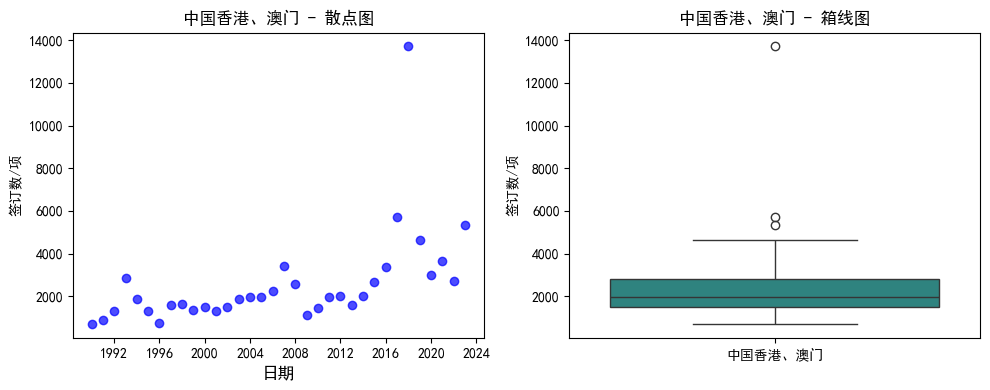

-------------- IQR清理 --------------
原始数据统计信息 (中国香港、澳门):
count       34.000000
mean      2573.117647
std       2306.554991
min        699.000000
25%       1472.500000
50%       1966.500000
75%       2808.000000
max      13703.000000
Name: 中国香港、澳门, dtype: float64
异常值范围：[-530.75, 4811.25]
清理后的数据统计信息 (中国香港、澳门):
count      31.000000
mean     2024.225806
std       911.967094
min       699.000000
25%      1413.500000
50%      1885.000000
75%      2627.500000
max      4622.000000
Name: 中国香港、澳门, dtype: float64
移除的异常值数量：3 (8.82%)
----------------------------
            中国香港、澳门
日期                 
1990-01-01      699
1991-01-01      885
1992-01-01     1330
1993-01-01     2834
1994-01-01     1885
-------------- 三次样条插值 --------------
插值后的数据统计信息 (中国香港、澳门):
count      33.000000
mean     2193.997657
std      1117.754970
min       699.000000
25%      1472.000000
50%      1959.000000
75%      2730.000000
max      5204.155730
Name: 中国香港、澳门, dtype: float64
----------------------------
            中国香港、澳门

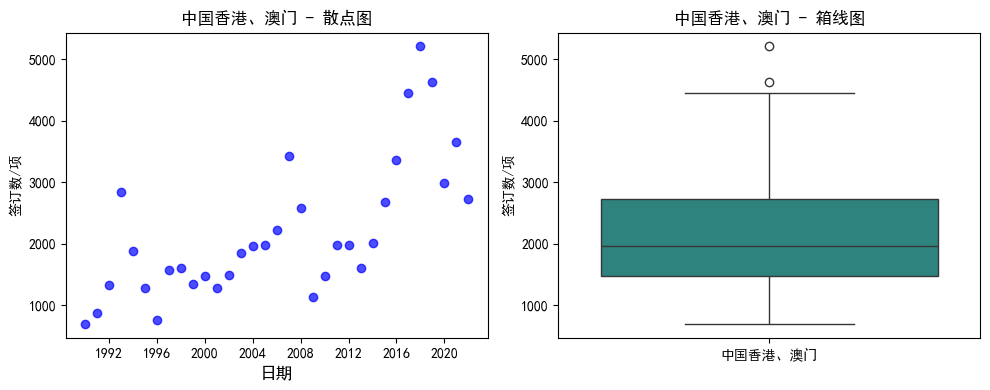

In [5]:
# 绘制原图像
plots_scatterAboxplot(df_total)
inputs = int(input())
# if need_to_predict == "其他" or "中国台湾":
if inputs == 0:
    print(df_total.head())
# elif need_to_predict == "中国香港、澳门" or "新加坡" or "韩国":
elif inputs == 1:
    df_total = IQR_fun(df_total)
    print(df_total.head())
    # 输出插值后的数据
    df_total = interpolation_fun(df_total)
    print(df_total.head())
    plots_scatterAboxplot(df_total)
# elif need_to_predict ==: 
elif inputs == 2:
    df_total = three_sigma(df_total)
    print(df_total.head())
    # 输出插值后的数据
    df_total = interpolation_fun(df_total)
    print(df_total.head())
    plots_scatterAboxplot(df_total)
else:
    # 输出清理后的数据
    df_total = three_sigma(df_total)
    df_total = IQR_fun(df_total)
    print(df_total.head())
    # 输出插值后的数据
    df_total = interpolation_fun(df_total)
    plots_scatterAboxplot(df_total)

# df_total[need_to_predict] = df_total[need_to_predict] // int(df_total[need_to_predict].mean())

### 划分训练、测试集
#### 使用 60% 内容用于训练，40% 用于测试

In [6]:
X = df_total.values
size = int(len(X) * 0.60)
train, test = X[0:size], X[size:len(X)]

# 输出划分后的训练集和测试集
# print("训练集：")
# print(train)
# print("\n测试集：")
# print(test)

# 初始化历史数据列表，用于存储训练集中的数据
history = [x for x in train]

In [7]:
# 寻找最佳ARIMA模型参数
def find_best_arima_params(train_data, max_p=5, max_d=2, max_q=5):
    best_aic = float("inf")
    best_bic = float("inf")
    best_order = None
    
    for p in trange(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore', category=UserWarning)
                    try:
                        model = ARIMA(train_data, order=(p, d, q))
                        model_fit = model.fit()
                        current_aic = model_fit.aic
                        current_bic = model_fit.bic
                        
                        # 同时更新AIC和BIC的最低值
                        if current_aic < best_aic:
                            best_aic = current_aic
                            best_order = (p, d, q)
                        if current_bic < best_bic:
                            best_bic = current_bic
                            best_order = (p, d, q)
                        # print(f"order = ({p, d, q})", end="\t")
                        # print(f'AIC: {current_aic}\tBIC: {current_bic}')
                    except:
                        continue
    
    # 返回最终选中的order及其对应的AIC/BIC
    return best_order, best_aic, best_bic



best_order, aic, bic = find_best_arima_params(train)
print(f'Best ARIMA order: {best_order}')
print(f'AIC: {aic}, BIC: {bic}')

100%|██████████| 6/6 [00:09<00:00,  1.62s/it]

Best ARIMA order: (5, 1, 3)
AIC: 18.0, BIC: 26.01334582106548


In [8]:
# 初始化预测结果列表
predictions = list()
# 对测试集中的每个时间点进行预测
print("当前最佳ARIMA参数：",best_order)
for t in trange(len(test)):
    # 使用历史数据拟合 ARIMA 模型
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=UserWarning)
        try:
            model = ARIMA(history, order=best_order)
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
            # print(f'预测值：{yhat:.0f}\t实际观测值：{obs[0]}')
        except:
            continue

# 计算预测结果的评估指标
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)
mape = np.mean(np.abs((test - predictions) / test)) * 100

# 输出评估指标
print(f'实际值与预测值之间的均方误差 (MSE): {mse:.3f}')
print(f'实际值与预测值之间的均方根误差 (RMSE): {rmse:.3f}')
print(f'实际值与预测值之间的平均绝对误差 (MAE): {mae:.3f}')
print(f'实际值与预测值之间的平均绝对百分比误差 (MAPE): {mape:.3f}%')

当前最佳ARIMA参数： (5, 1, 3)


100%|██████████| 14/14 [00:02<00:00,  6.68it/s]

实际值与预测值之间的均方误差 (MSE): 904256.243
实际值与预测值之间的均方根误差 (RMSE): 950.924
实际值与预测值之间的平均绝对误差 (MAE): 806.043
实际值与预测值之间的平均绝对百分比误差 (MAPE): 59.572%


ADF检验结果：
ADF检验统计量 : -2.14212731525559
p值 : 0.22791569987086968
使用的滞后数 : 0
使用的观测值数量 : 32
反对零假设的弱证据，时间序列有一个单位根，表明它是非平稳的。

1阶差分：
ADF检验结果：
ADF检验统计量 : -3.8023081063677933
p值 : 0.002883788130273987
使用的滞后数 : 8
使用的观测值数量 : 23
反对原假设(H0)的有力证据，否定原假设。数据没有单位根，并且是平稳的。



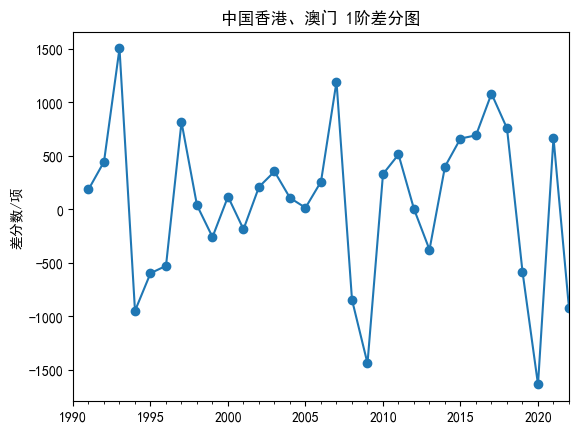

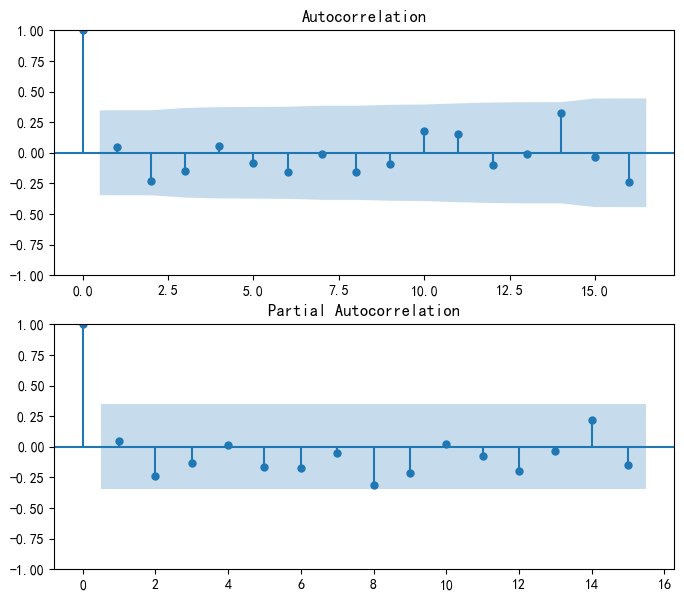

In [9]:
# ADF 检验函数
# H0：它是非平稳的  
# H1：它是平稳的
def adfuller_test(sales, title=""):
    result = adfuller(sales)
    labels = ['ADF检验统计量', 'p值', '使用的滞后数', '使用的观测值数量']
    print(f"{title}ADF检验结果：")
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))
    if result[1] <= 0.05:
        print("反对原假设(H0)的有力证据，否定原假设。数据没有单位根，并且是平稳的。\n")
    else:
        print("反对零假设的弱证据，时间序列有一个单位根，表明它是非平稳的。\n")

d = best_order[1]  # 获取最佳ARIMA参数中的差分阶数

# ADF 检验1：原始数据平稳性检验
adfuller_test(df_total[need_to_predict])

df_total[f'{d}阶差分'] = df_total[need_to_predict] - df_total[need_to_predict].shift(d)

# ADF 检验2：经过d阶差分后的数据平稳性检验
print(f'{d}阶差分：')
adfuller_test(df_total[f'{d}阶差分'].dropna())

# 绘制可视化图像
df_total[f'{d}阶差分'].plot(kind='line', marker='o')
plt.title(f"{need_to_predict} {d}阶差分图")
plt.ylabel('差分数/项')
plt.show()

# 绘制自相关函数（ACF）图和偏自相关函数（PACF）图
fig1 = plt.figure(figsize=(8, 7))
ax1 = fig1.add_subplot(211)
fig1 = plot_acf(df_total[f'{d}阶差分'].dropna(), lags=len(df_total[need_to_predict])//2, ax=ax1)  # 绘制自相关函数（ACF）图
ax2 = fig1.add_subplot(212)
fig1 = plot_pacf(df_total[f'{d}阶差分'].dropna(), lags=len(df_total[need_to_predict])//2 - 1, ax=ax2)  # 偏自相关函数（PACF）图
plt.show()

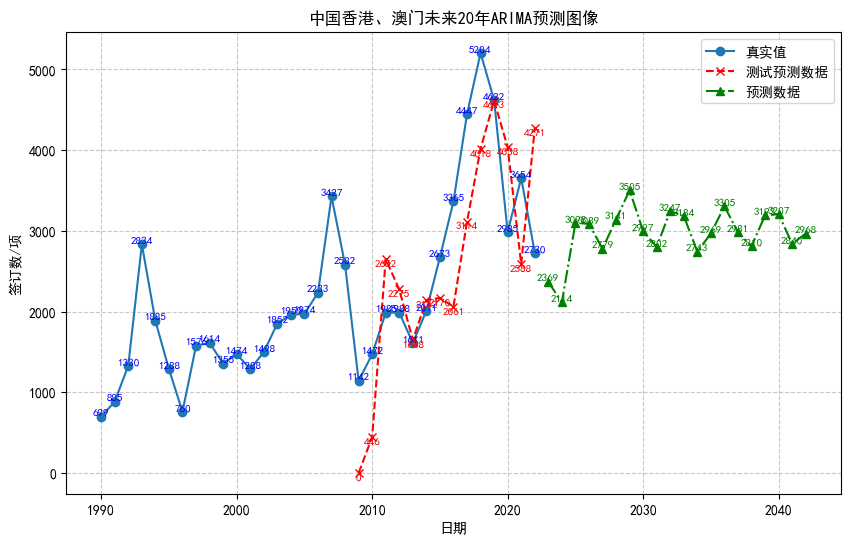

In [10]:
# 绘制预测图像
model = ARIMA(X, order=best_order)
model_fit = model.fit()
future_forecast = model_fit.forecast(steps=years_to_predicted)

# 创建未来年份的索引
last_year = df_total.index[-1].year
future_years = [datetime(year=last_year + i + 1, month=1, day=1) for i in range(years_to_predicted)]

# 绘制实际值、测试集预测值和未来预测值的对比图
plt.figure(figsize=(10, 6))  # 设置图像大小
plt.plot(df_total.index, X, label='真实值', marker='o')  # 绘制实际值曲线
plt.plot(df_total.index[size:], predictions, color='red', label='测试预测数据', linestyle='--', marker='x')  # 绘制测试集预测值曲线
plt.plot(future_years, future_forecast, color='green', label='预测数据', linestyle='-.', marker='^')  # 绘制未来预测值曲线
plt.legend()  # 添加图例
plt.title(f'{need_to_predict}未来{years_to_predicted}年ARIMA预测图像')  # 添加标题
plt.xlabel('日期')  # 添加X轴标签
plt.ylabel('签订数/项')  # 添加Y轴标签
plt.grid(True, linestyle='--', alpha=0.7)  # 添加网格线

# 在每个数据点上显示数值
for i, value in enumerate(X):
    value = value[0]
    plt.text(df_total.index[i], value, f'{value:.0f}', ha='center', va='bottom', fontsize=8, color='blue')

for i, value in enumerate(predictions):
    plt.text(df_total.index[size:][i], value, f'{value:.0f}', ha='center', va='top', fontsize=8, color='red')

for i, value in enumerate(future_forecast):
    plt.text(future_years[i], value, f'{value:.0f}', ha='center', va='bottom', fontsize=8, color='green')

# plt.show()  # 显示图像
plt.savefig(f"out_file/out_fig/{need_to_predict}的未来{years_to_predicted}年合同签订项预测图像.png")

In [11]:
# 保存文件
last_year = df_total.index[-1].year
future_years = [datetime(year=last_year + i + 1, month=1, day=1) for i in range(years_to_predicted)]

# 创建包含预测年份和预测数据的DataFrame
future_df = pd.DataFrame({
    '日期': future_years,
    f'{need_to_predict}预测数据（项）': future_forecast.round().astype(int)
})

# 保存到Excel文件
future_df.to_excel(f'out_file/out_excel/{need_to_predict}的未来{years_to_predicted}年合同签订项数量预测.xlsx', index=False)
